In [1]:
import pandas as pd
import numpy as np
from superugby import cleanup
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
results = pd.read_csv("https://raw.githubusercontent.com/kieranbd/superrugby-predictor/master/super_rugby_oddsportal.csv").drop('Play-off Game?', axis=1).dropna()

Take a look at the upcoming fixtures (for weekend 15 March, 2019)

In [3]:
results.head(6)

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,3-May-19,Crusaders,Sharks,0.0,0.0,1.05,40.40,9.20,11.0
1,3-May-19,Reds,Sunwolves,0.0,0.0,1.30,24.04,3.59,11.0
2,4-May-19,Hurricanes,Rebels,0.0,0.0,1.22,27.73,4.29,10.0
3,4-May-19,Highlanders,Chiefs,0.0,0.0,1.23,26.59,4.17,10.0
4,4-May-19,Brumbies,Blues,0.0,0.0,2.03,20.48,1.82,10.0
5,4-May-19,Bulls,Waratahs,0.0,0.0,1.35,23.15,3.27,10.0


## Engineer features which capture form
The functions below will work row-by-row, returning the win (or loss) streak for both home and away teams.

### Home and away streak
Home streak is the active win (or loss) streak for the team playing at home, in their most recent home games.   
Away streak is the same, but for the visiting team in their most recent away fixtures.   

### Home and away margins
Home average margin is the average margin (relative to home team) for the home team in their last n games at home. For example, a value of 5 means that the home side in this fixture is averaging a winning margin of 5 in their last n games at home.   

Away average margin is the same, but for the visiting team in last n away games. A positive number means that the away side has scored more points away from home than they have conceded in last n away games.   

## Encode all team names and nationalities
All team names have been one hot encoding into separate columns, with additional columns for the (generalized) nationalities of the teams.

In [4]:
df = cleanup(results)
df.head(10)

,Date,home_margin,home_win,home_streak,home_avg_marg,away_streak,away_avg_marg,home_country_AUS,home_country_NZ,home_country_SA,...,away_team_Hurricanes,away_team_Jaguares,away_team_Lions,away_team_Rebels,away_team_Reds,away_team_Sharks,away_team_Stormers,away_team_Sunwolves,away_team_Waratahs,home_odds
0,2019-05-03,0.0,False,25,23.8,2,5.4,0,1,0,...,0,0,0,0,0,1,0,0,0,0.897561
1,2019-05-03,0.0,False,1,7.4,-1,-3.6,1,0,0,...,0,0,0,0,0,0,0,1,0,0.734151
2,2019-05-04,0.0,False,1,3.2,-1,-2.4,0,1,0,...,0,0,0,1,0,0,0,0,0,0.778584
3,2019-05-04,0.0,False,1,-0.6,-1,9.4,0,1,0,...,0,0,0,0,0,0,0,0,0,0.772222
4,2019-05-04,0.0,False,3,11.8,-6,-15.2,1,0,0,...,0,0,0,0,0,0,0,0,0,0.472727
5,2019-05-04,0.0,False,1,-7.2,-2,-4.2,0,0,1,...,0,0,0,0,0,0,0,0,1,0.707792
6,2019-05-04,0.0,False,1,4.2,1,-3.2,0,0,0,...,0,0,0,0,0,0,1,0,0,0.619165
7,2019-04-26,26.0,True,24,22.4,1,3.8,0,1,0,...,0,0,1,0,0,0,0,0,0,0.883188
8,2019-04-26,-52.0,False,-6,-7.2,-5,-9.6,0,0,0,...,0,0,0,0,0,0,0,0,0,0.262195
9,2019-04-27,28.0,True,-2,-1.8,4,9.2,0,1,0,...,0,0,0,0,0,0,0,0,0,0.777778


## Model fitting

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [6]:
# scale numerical features
scaler = StandardScaler()

numeric = ['home_streak', 'home_avg_marg', 'away_streak', 'away_avg_marg', 'home_odds']
df[numeric] = scaler.fit_transform(df[numeric].astype('float64'))

In [7]:
df.head()

,Date,home_margin,home_win,home_streak,home_avg_marg,away_streak,away_avg_marg,home_country_AUS,home_country_NZ,home_country_SA,...,away_team_Hurricanes,away_team_Jaguares,away_team_Lions,away_team_Rebels,away_team_Reds,away_team_Sharks,away_team_Stormers,away_team_Sunwolves,away_team_Waratahs,home_odds
0,2019-05-03,0.0,False,5.919478,1.919640,0.923762,1.022019,0,1,0,...,0,0,0,0,0,1,0,0,0,1.416771
1,2019-05-03,0.0,False,-0.064982,0.286724,0.039759,0.102933,1,0,0,...,0,0,0,0,0,0,0,1,0,0.653908
2,2019-05-04,0.0,False,-0.064982,-0.131462,0.039759,0.225478,0,1,0,...,0,0,0,1,0,0,0,0,0,0.861339
3,2019-05-04,0.0,False,-0.064982,-0.509820,0.039759,1.430501,0,1,0,...,0,0,0,0,0,0,0,0,0,0.831638
4,2019-05-04,0.0,False,0.433723,0.724824,-1.433580,-1.081666,1,0,0,...,0,0,0,0,0,0,0,0,0,-0.566526


In [8]:
X = df[7:].drop(['Date', 'home_margin', 'home_win'], axis=1).values.astype(np.float64)
y = df[7:].home_margin.values.astype(np.float64)

In [9]:
# we will use these later:
X_temp = df[:7].drop(['Date', 'home_margin', 'home_win'], axis=1).values.astype(np.float64)
y_temp = df[:7].home_margin.values.astype(np.float64)

In [10]:
y.shape

(1290,)

In [11]:
X.shape

(1290, 41)

In [12]:
# from tpot import TPOTRegressor

In [13]:
# tpot = TPOTRegressor(scoring='neg_mean_absolute_error',
#                      n_jobs=-1,
#                      verbosity=2,
#                      max_time_mins=25)

In [14]:
# tpot.fit(X, y)

In [15]:
# tpot.score(X, y)*-1

In [16]:
# tpot.export('tpot_pipeline.py')

In [17]:
!type tpot_pipeline.py

import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFwe, f_regression
from sklearn.linear_model import ElasticNetCV, LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator, ZeroCount

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:-11.188556355715761
exported_pipeline = make_pipeline(
    ZeroCount(),
    StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.99, learning_rate=0.01, loss="quantile", max_depth=4, max_features=0.950

## Build TPOT model

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFwe, f_regression
from sklearn.linear_model import ElasticNetCV, LassoLarsCV
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator, ZeroCount

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Average CV score on the training set was:-11.188556355715761
pipeline = make_pipeline(
    ZeroCount(),
    StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.99,
                                                          learning_rate=0.01,
                                                          loss="quantile",
                                                          max_depth=4,
                                                          max_features=0.95,
                                                          min_samples_leaf=17,
                                                          min_samples_split=8,
                                                          n_estimators=100,
                                                          subsample=0.35)),
    StackingEstimator(estimator=ElasticNetCV(l1_ratio=0.05, tol=0.1, cv=5)),
    SelectFwe(score_func=f_regression, alpha=0.031),
    LassoLarsCV(normalize=True, cv=5)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('zerocount', ZeroCount()), ('stackingestimator-1', StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.99, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='quantile', max_depth=4,
             max_features=0.95, max_leaf_nodes=None,
             min_impur..._alphas=1000, n_jobs=None, normalize=True,
      positive=False, precompute='auto', verbose=False))])

In [21]:
# Use the model's predict method on the test data
np.sqrt(mean_squared_error(pipeline.predict(X_test), y_test))

14.592412167651773

In [22]:
mean_absolute_error(y_test, pipeline.predict(X_test))

11.084708171721552

In [23]:
import matplotlib.pyplot as plt

In [24]:
errs = abs(y_test-pipeline.predict(X_test))

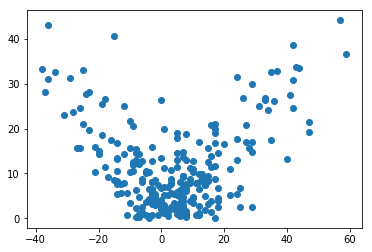

In [25]:
plt.scatter(x=y_test, y=errs)

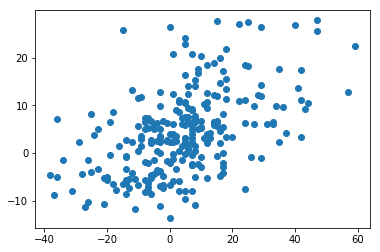

In [26]:
plt.scatter(x=y_test, y=pipeline.predict(X_test))
plt.show()

### Try 2018 season as a test run

In [27]:
# save a copy of the 2019 season as a test
mask_2018 = (df['Date'] > pd.to_datetime('2018-01-01')) & (df['Date'] <= pd.to_datetime('2019-01-01'))
df_2018 = df[mask_2018]

X_test = df_2018.drop(['Date', 'home_margin', 'home_win'], axis=1).values.astype(np.float64)
y_test = df_2018.home_margin.values.astype(np.float64)

In [28]:
# keep all other matches as training set
mask_pre_2018 = df['Date'] < pd.to_datetime('2018-01-01')
df_pre_2018 = df[mask_pre_2018]

X_train = df_pre_2018.drop(['Date', 'home_margin', 'home_win'], axis=1).values.astype(np.float64)
y_train = df_pre_2018.home_margin.values.astype(np.float64)

In [29]:
results_2018 = results[mask_2018][['Home_Team', 'Away_Team', 'home_margin', 'Home_Odds', 'Away_Odds']]
results_2018['home_odds'] = results_2018.Away_Odds / (results_2018.Home_Odds + results_2018.Away_Odds)
results_2018.drop(['Home_Odds', 'Away_Odds'], axis=1, inplace=True)

In [30]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('zerocount', ZeroCount()), ('stackingestimator-1', StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.99, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='quantile', max_depth=4,
             max_features=0.95, max_leaf_nodes=None,
             min_impur..._alphas=1000, n_jobs=None, normalize=True,
      positive=False, precompute='auto', verbose=False))])

In [31]:
mean_absolute_error(y_test, pipeline.predict(X_test))

11.61909008344809

In [32]:
results_2018['prediction'] = np.round(pipeline.predict(X_test),0)

In [33]:
results_2018['error'] = abs(results_2018.home_margin - results_2018.prediction)
results_2018['win_point'] = (results_2018.home_margin * results_2018.prediction>0).astype('int')
results_2018['margin_point'] = (results_2018.error<=5).astype('int')

In [34]:
results_2018.head()

,Home_Team,Away_Team,home_margin,home_odds,prediction,error,win_point,margin_point
91,Crusaders,Lions,19.0,0.867470,16.0,3.0,1,1
92,Lions,Waratahs,18.0,0.774312,10.0,8.0,1,0
93,Crusaders,Hurricanes,18.0,0.737271,11.0,7.0,1,0
94,Lions,Jaguares,17.0,0.759615,9.0,8.0,1,0
95,Waratahs,Highlanders,7.0,0.418782,-3.0,10.0,0,0


In [35]:
# how often is the winner correctly predicted?
results_2018.win_point.agg('mean')

0.7086614173228346

In [36]:
# how often is the scoreline predicted within 5 points?
results_2018.margin_point.agg('mean')

0.30708661417322836

In [37]:
# compare win points to success rate of bookmakers
home_wins = (results_2018['home_margin'] > 0).values

In [38]:
home_favourites = (results_2018.home_odds>.5).values

In [39]:
np.mean(home_wins == home_favourites)

0.7165354330708661

---

## Make predictions for upcoming week

In [40]:
# fit to full data set
pipeline.fit(X, y)

Pipeline(memory=None,
     steps=[('zerocount', ZeroCount()), ('stackingestimator-1', StackingEstimator(estimator=GradientBoostingRegressor(alpha=0.99, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='quantile', max_depth=4,
             max_features=0.95, max_leaf_nodes=None,
             min_impur..._alphas=1000, n_jobs=None, normalize=True,
      positive=False, precompute='auto', verbose=False))])

In [42]:
temp = np.vstack((pipeline.predict(X_temp).reshape(7), results['Home_Team'][:7], results['Away_Team'][:7])).T

In [43]:
preds_df = pd.DataFrame(temp, columns=["Home_Margin", "Home_Team", "Away_Team"])

In [44]:
preds_df["Home_Margin"] = preds_df.Home_Margin.apply(lambda x: int(np.round(x, 0)))
preds_df

,Home_Margin,Home_Team,Away_Team
0,23,Crusaders,Sharks
1,7,Reds,Sunwolves
2,13,Hurricanes,Rebels
3,8,Highlanders,Chiefs
4,0,Brumbies,Blues
5,6,Bulls,Waratahs
6,3,Jaguares,Stormers
